In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

# Step 1: Explore the data

In difference in differences, we are looking for a situation where at some point, the treatment changes for one group but not the other. In a sense, diff in diff is also looking for discontinuity similar to regression discontinuity design, only now the discontinuity needs to be over time.

This will allow us to compare in multiple directions: the treatment group against the control group and the treatment group after the intervention against the same treatment group but before the intervention.

So in our exploration we will look for time periods where discount assignment changed for some customers but not for others.

In [87]:
df = pd.read_csv('diff_in_diff.csv')
df

,sales,discount,age,gender,cust_state,tenure,profit,month
0,1153.28,0,25,O,MA,19,57.66,7
1,1978.13,0,26,M,MG,16,98.91,6
2,1095.70,0,26,W,RJ,20,54.78,2
3,2404.90,25,30,W,BA,18,95.24,6
4,1704.80,0,38,M,PB,15,85.24,4
...,...,...,...,...,...,...,...,...
49995,2083.30,0,29,W,SP,15,104.17,0
49996,1110.16,25,29,W,MT,16,30.51,13
49997,2495.62,25,31,M,MG,18,99.78,11
49998,1951.28,0,30,O,SP,24,97.56,0


In [88]:
df.dtypes
# gender seems to have null values, which we expected as these are self-reported

sales         float64
discount        int64
age             int64
gender         object
cust_state     object
tenure          int64
profit        float64
month           int64
dtype: object

In [89]:
df_group = df.groupby(by=['month', 'gender']).agg(
    {'discount':'mean'}
).reset_index()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='month', ylabel='discount'>

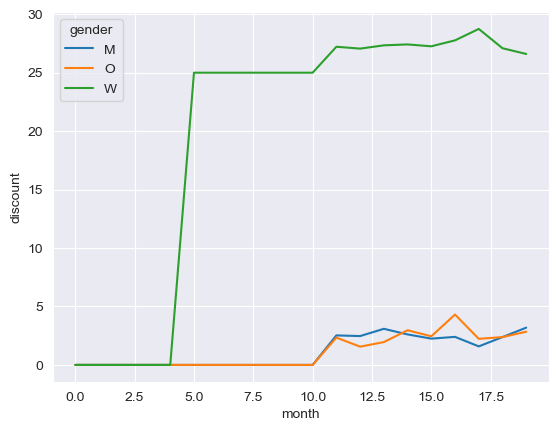

In [90]:
sns.lineplot(data=df_group, x='month', y='discount', hue='gender')

We observe that the discounts for women increase from 0 to 25+ starting at month 5. For men and other, the discount increases from 0 to <5 after month 10.

In [91]:
state_df = df.groupby(by=['cust_state', 'month']).agg({'discount':'mean',
                                                  'profit':'mean'}).reset_index()
state_df

,cust_state,month,discount,profit
0,AC,0,0.000000,42.190000
1,AC,1,0.000000,42.866000
2,AC,2,0.000000,43.717143
3,AC,3,0.000000,42.665455
4,AC,4,0.000000,38.514000
...,...,...,...,...
531,TO,15,18.750000,36.892500
532,TO,16,25.000000,40.995000
533,TO,17,12.500000,51.265000
534,TO,18,8.333333,48.150000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='month', ylabel='discount'>

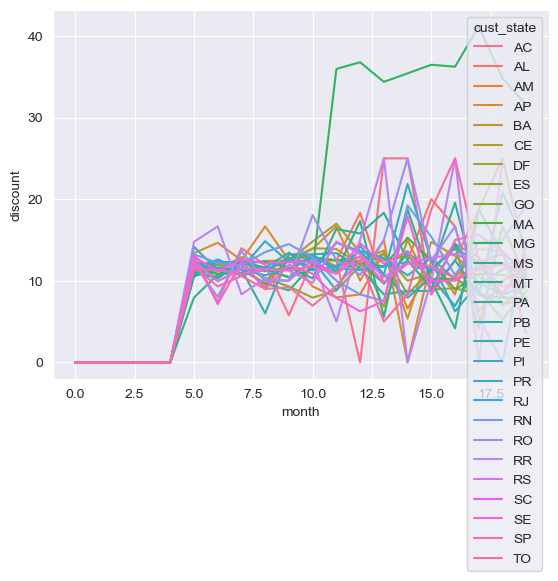

In [92]:
sns.lineplot(data=state_df, x='month', y='discount', hue='cust_state')

We can see that state MG increases discount to >30 starting month 11. All states start some form of discount between 0 and 25 starting month 5.

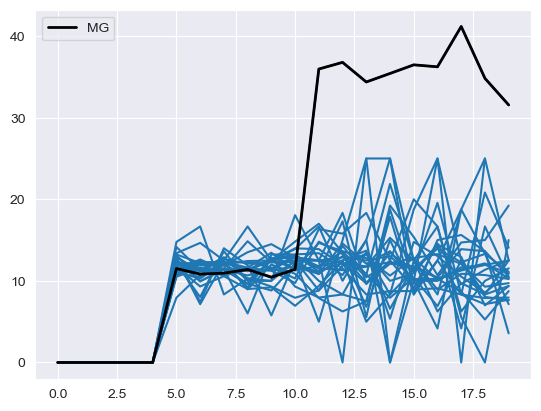

In [93]:
for state in state_df.cust_state.unique():
    plt.plot(state_df.query(f"cust_state == '{state}'")['month'], state_df.query(f"cust_state == '{state}'")['discount'], c="C0")
plt.plot(state_df.query("cust_state == 'MG'")['month'],
         state_df.query("cust_state == 'MG'")['discount'], label="MG", lw=2,
         color="black")
plt.legend()

# Step 2: Before and after 

We learnt that women get higher discount after month 5, we want to know how to leverage that increase to estimate the causal effect of discount on profits, so we can know if discounts are profitable or not.

In [94]:
df_w = df.copy()
df_w['post_intervention'] = np.where(df['month'] >= 5, True, False)
df_w['treated'] = np.where(df['gender']=='W', True, False)

In [95]:
df_did = df_w.groupby(['post_intervention','treated'])['profit'].mean().reset_index()
df_did

,post_intervention,treated,profit
0,False,False,80.527533
1,False,True,78.176658
2,True,False,92.442781
3,True,True,85.318404


The average profit for the treated group (women) before the intervention is 78 and post intervention is 85. The profit increased post discount increase by ~7. 
For the treated, it can be interpreted as the average causal effect of discount on profit if women's profit is not changing with time. That is, only if, there were no discount (potential outcome 0), women's profit before and after the intervention were the same.

Also worth observing that for the untreated, the profit increased after month 4 (intervention period for the treated) from 80 to 92, a ~12 point increase.

Looking at this another way, the difference in profits after intervention between the treated and control group is ~-7 (85-92). The profit is lower in the treated after intervention than in the control. The causal effect of discount on profit is valid if there are not any confounders. We can interpret this as the average causal effect of the discount on profit only if women's profit would be the same as men's if there were no discount for women.

# Step 3: Difference in Differences


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='month', ylabel='profit'>

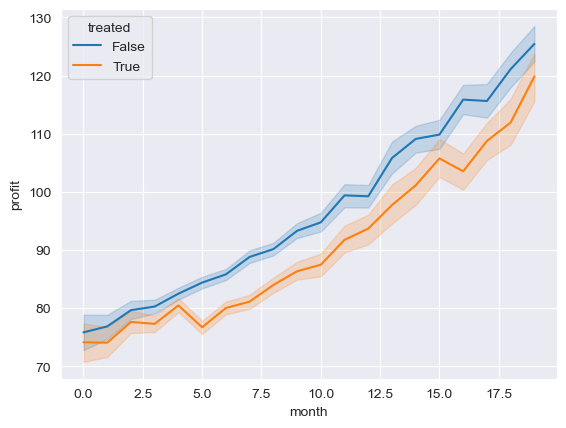

In [96]:
 sns.lineplot(data=df_w, x='month', y='profit', hue='treated')

The treated and control do not have the same profit levels before the intervention.
The average profit for the treatment and control is growing before the intervention.
The treated and control groups have a reasonably parallel profit trend before the intervention period.

In [97]:
control_after = df_did.loc[(df_did['post_intervention']==True) & (df_did['treated']==False),'profit'].mean()
control_before = df_did.loc[(df_did['post_intervention']==False) & (df_did['treated']==False),'profit'].mean()

treated_after = df_did.loc[(df_did['post_intervention']==True) & (df_did['treated']==True),'profit'].mean()
treated_before = df_did.loc[(df_did['post_intervention']==False) & (df_did['treated']==True),'profit'].mean()

diff_in_diff = (treated_after - treated_before) - (control_after - control_before) 

diff_in_diff

-4.773501642136651

The impact of discounts on profits according to diff in diff is 4.77 profit points. Let's use regression to get the diff-in-diff estimator.

In [98]:
model = smf.ols(formula='profit ~ treated*post_intervention', data=df_w).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     511.6
Date:                Mon, 29 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:40:47   Log-Likelihood:            -2.4221e+05
No. Observations:               50000   AIC:                         4.844e+05
Df Residuals:                   49996   BIC:                         4.845e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    80.5275      0.342    235.715      0.000      79.858      81.197
treated[T.True]                              -2.3509      0.532     -4.421      0.000      -3.393      -1.309
post_intervention[T.True]                    11.9152      0.402     29.673      0.000      11.128      12.702
treated[T.True]:post_intervention[T.True]    -4.7735      0.625     -7.642      0.000      -5.998      -3.549
==============================================================================
Omnibus:                     4792.696   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24089.614
Skew:                           0.338   Prob(JB):                         0.00
Kurtosis:                       6.332   Cond. No.                         8.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The interaction coefficient matches the value we found for diff-in-diff estimator.

Diff-in-diff is a valid estimator if there is a parallel trend relationship in the dependent variable for the treated and the control.

# Step 4: Synthetic Controls

What do we do when we do not have a similar growth trajectory for the treated and the control?
For this, we'll go back to the 'MG' state variation where it is the only state to see a discount treatment at month 10 while remaining roughly unchanged for the other states.

In order to leverage this source of variation, we will learn a new technique called synthetic control. The idea is that instead of using a single state as a control, we can combine multiple control states into what we call, a synthetic control, an artificially generated state that behaves just like 'MG' in the pre-intervention period. We use the synthetic state's behaviour after the intervention period as a control to compare against the state of 'MG'.


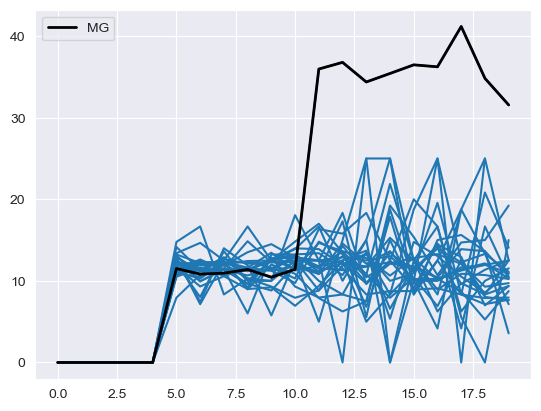

In [99]:
for state in state_df.cust_state.unique():
    plt.plot(state_df.query(f"cust_state == '{state}'")['month'], state_df.query(f"cust_state == '{state}'")['discount'], c="C0")
plt.plot(state_df.query("cust_state == 'MG'")['month'],
         state_df.query("cust_state == 'MG'")['discount'], label="MG", lw=2,
         color="black")
plt.legend()

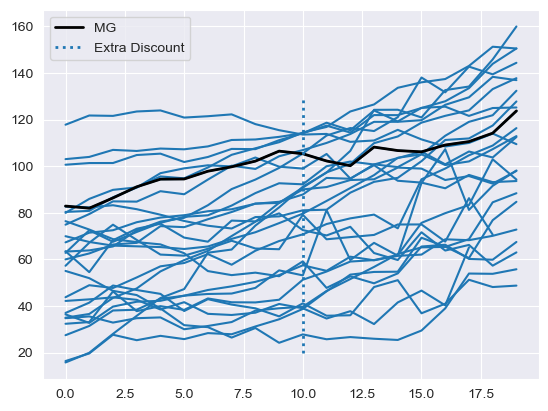

In [100]:
#Plotting profit for all states

for state in state_df.cust_state.unique():
    plt.plot(state_df.query(f"cust_state == '{state}'")['month'], state_df.query(f"cust_state == '{state}'")['profit'], c="C0")
plt.plot(state_df.query("cust_state == 'MG'")['month'],
         state_df.query("cust_state == 'MG'")['profit'], label="MG", lw=2,
         color="black")
plt.vlines(x=10, ymin=20, ymax=130, linestyle=":", lw=2, label="Extra Discount")
plt.legend()

We hve many states and many time periods, so there isn't a clear control we can compare against the treated state, MG. Synthetic control can be seen as a horizontal regression for this purpose. 

In [101]:
inverted = state_df.pivot_table(index='month', columns='cust_state', values='profit',fill_value=0).reset_index()
inverted 

cust_state,month,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,0,42.190000,55.047647,62.797273,63.494000,67.307551,79.947778,15.791429,80.367273,117.773462,...,74.887059,69.956111,63.357000,43.776667,57.260000,34.999444,27.495625,16.405000,103.014244,37.040000
1,1,42.866000,51.954800,72.500000,54.530000,71.463093,85.956667,19.945625,80.817200,121.725758,...,79.460299,67.488941,63.868947,48.931429,67.148000,36.594308,31.455455,19.660000,103.956466,41.450000
2,2,43.717143,46.515135,67.556275,68.231667,72.513684,89.837619,28.060938,86.637955,121.561389,...,84.896723,65.903920,65.550698,47.741579,74.894286,43.493920,38.083846,27.690455,106.974268,48.804375
3,3,42.665455,44.704032,71.761605,73.148889,75.950916,90.885620,35.793043,90.811477,123.448310,...,84.782019,65.616638,72.470250,52.260937,68.352500,47.541168,38.429041,25.347059,106.514163,46.877778
4,4,38.514000,38.983294,75.687207,75.322500,77.949444,95.577831,43.432821,96.985339,123.895369,...,89.253986,65.287454,76.204337,57.030682,62.072500,54.860063,43.115078,27.216154,107.545872,45.217353
5,5,41.649310,31.797368,78.271926,69.351786,78.952319,94.778441,47.277660,99.057559,120.839486,...,87.948212,64.472000,77.841933,58.454667,61.603636,59.706278,44.414685,25.810875,107.225881,37.867500
6,6,36.657037,30.944731,78.913917,67.600000,80.666347,99.432095,62.873523,100.371389,121.417048,...,94.249459,65.543528,83.237983,62.283774,64.559333,63.646376,46.875233,28.390714,108.470502,42.945490
7,7,36.162400,26.473636,83.099060,76.647000,81.501328,104.863297,64.232796,99.888250,122.207006,...,100.197857,68.812020,90.171667,57.726970,68.001905,70.021509,48.431675,27.899589,111.223821,40.630385
8,8,37.150000,30.585846,88.439079,76.303810,83.881258,107.663279,74.505429,103.699500,118.027143,...,98.802412,71.648874,94.235135,63.720400,64.678824,76.161011,50.369689,31.233208,111.441579,39.010800
9,9,40.888462,24.237636,92.662500,79.745000,84.712735,110.268134,82.303333,99.777442,115.425941,...,104.245579,75.562397,99.234200,67.879333,64.364000,84.247566,53.267727,34.320000,112.560400,35.575263


In [102]:
preintervention = inverted[inverted['month']<11]
preintervention

cust_state,month,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,0,42.190000,55.047647,62.797273,63.494000,67.307551,79.947778,15.791429,80.367273,117.773462,...,74.887059,69.956111,63.357000,43.776667,57.260000,34.999444,27.495625,16.405000,103.014244,37.040000
1,1,42.866000,51.954800,72.500000,54.530000,71.463093,85.956667,19.945625,80.817200,121.725758,...,79.460299,67.488941,63.868947,48.931429,67.148000,36.594308,31.455455,19.660000,103.956466,41.450000
2,2,43.717143,46.515135,67.556275,68.231667,72.513684,89.837619,28.060938,86.637955,121.561389,...,84.896723,65.903920,65.550698,47.741579,74.894286,43.493920,38.083846,27.690455,106.974268,48.804375
3,3,42.665455,44.704032,71.761605,73.148889,75.950916,90.885620,35.793043,90.811477,123.448310,...,84.782019,65.616638,72.470250,52.260937,68.352500,47.541168,38.429041,25.347059,106.514163,46.877778
4,4,38.514000,38.983294,75.687207,75.322500,77.949444,95.577831,43.432821,96.985339,123.895369,...,89.253986,65.287454,76.204337,57.030682,62.072500,54.860063,43.115078,27.216154,107.545872,45.217353
5,5,41.649310,31.797368,78.271926,69.351786,78.952319,94.778441,47.277660,99.057559,120.839486,...,87.948212,64.472000,77.841933,58.454667,61.603636,59.706278,44.414685,25.810875,107.225881,37.867500
6,6,36.657037,30.944731,78.913917,67.600000,80.666347,99.432095,62.873523,100.371389,121.417048,...,94.249459,65.543528,83.237983,62.283774,64.559333,63.646376,46.875233,28.390714,108.470502,42.945490
7,7,36.162400,26.473636,83.099060,76.647000,81.501328,104.863297,64.232796,99.888250,122.207006,...,100.197857,68.812020,90.171667,57.726970,68.001905,70.021509,48.431675,27.899589,111.223821,40.630385
8,8,37.150000,30.585846,88.439079,76.303810,83.881258,107.663279,74.505429,103.699500,118.027143,...,98.802412,71.648874,94.235135,63.720400,64.678824,76.161011,50.369689,31.233208,111.441579,39.010800
9,9,40.888462,24.237636,92.662500,79.745000,84.712735,110.268134,82.303333,99.777442,115.425941,...,104.245579,75.562397,99.234200,67.879333,64.364000,84.247566,53.267727,34.320000,112.560400,35.575263


In [103]:
y = preintervention['MG']
X = preintervention.drop(['MG','month'], axis=1)


In [104]:
from sklearn.linear_model import ElasticNet

elasticnet = ElasticNet(alpha=50, fit_intercept=False, max_iter=10000)
elasticnet.fit(X, y)

ElasticNet(alpha=50, fit_intercept=False, max_iter=10000)

In [105]:
weights = elasticnet.coef_
weights

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.15666702, 0.06709938, 0.15451208, 0.14239844, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11871068,
       0.        , 0.08386732, 0.        , 0.11140646, 0.        ,
       0.        , 0.00979641, 0.        , 0.        , 0.13232692,
       0.        ])

We have fit a model that has a high feature set but low number of samples so the situation is prone to overfitting. We use regularization to avoid that. alpha is a combination of l1 and l2 regularization. In our case we observe that the coefficient for a lot of states has turned to 0, we are using the weights from 9 other states to estimate the synthetic state similar to 'MG' in the pre-intervention period.

In [106]:
pd.DataFrame(dict(state=inverted.drop(columns=['MG','month']).columns, weights=weights))

,state,weights
0,AC,0.000000
1,AL,0.000000
2,AM,0.000000
3,AP,0.000000
4,BA,0.000000
5,CE,0.156667
6,DF,0.067099
7,ES,0.154512
8,GO,0.142398
9,MA,0.000000


In [107]:
synth = inverted.drop(columns=['MG','month']).fillna(0).values.dot(weights)

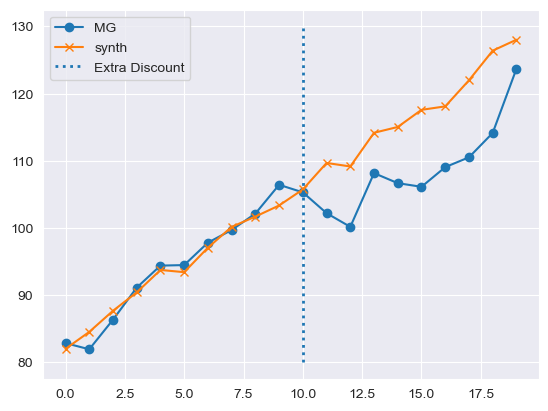

In [108]:
plt.plot(inverted['month'], inverted['MG'], label='MG', marker='o')
plt.plot(inverted['month'], synth, label='synth', marker='x')
plt.vlines(x=10, ymin=80, ymax=130, linestyle=":", lw=2, label="Extra Discount")
plt.legend()

The growth trajectory of MG dropped in the post intervention period from what would've been its trajectory based on the synthetic state. Here it is clear that the discount has a negative impact on profits. Let's plot only the difference in profit between the state of MG and the synthetic state.

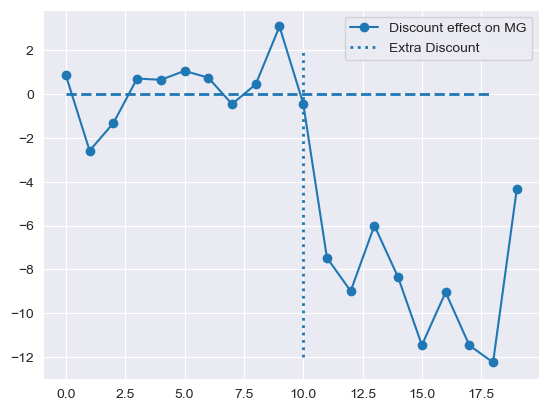

In [109]:
plt.plot(inverted['month'], inverted['MG']- synth, label="Discount effect on MG", marker='o')
plt.vlines(x=10, ymin=-12, ymax=2, linestyle=":", lw=2, label="Extra Discount")
plt.hlines(y=0, xmin=0, xmax=18, linestyle="--", lw=2)
plt.legend()

The profit of synthetic control keeps growing after hte intervention period, while the profit for the state of MG takes a dip. This shows the negative impact of discount on profit from the month 11 onward very clearly for the state of MG. the discount is not profitable.